In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.pytorch import PyTorch

from lstm_trader import fetch_bucketed_from_bitmex, preprocess, train, evaluate

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

.


In [3]:
preprocess(df, input_dir)

In [4]:
inputs = sagemaker_session.upload_data(path=input_dir, bucket=bucket, key_prefix='lstm-trader')

In [5]:
estimator = PyTorch(
    source_dir='lstm_trader',
    entry_point='trainer.py',
    hyperparameters={ 'hidden-dim': 64, 'n-epochs': 16, 'seq-len': 128, 'batch-size': 1024 },
    framework_version='1.2.0',
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
)

estimator.fit({ 'data_dir': inputs })

2019-12-28 09:50:50 Starting - Starting the training job...
2019-12-28 09:50:52 Starting - Launching requested ML instances.........
2019-12-28 09:52:23 Starting - Preparing the instances for training......
2019-12-28 09:53:33 Downloading - Downloading input data......
2019-12-28 09:54:33 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-28 09:56:38,458 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-28 09:56:38,482 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2019-12-28 09:56:37 Training - Training image download completed. Training in progress.2019-12-28 09:56:44,696 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-28 09:56:44,962 sagemaker-containers INFO     Module trainer does not provide a setup.py. 
Generating setup.py
2019-12-28 09:56

In [6]:
sagemaker_session.download_data(
    path=output_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name+'/output/output.tar.gz',
)
sagemaker_session.download_data(
    path=model_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name+'/output/model.tar.gz',
)
!tar xvf cache_output/output.tar.gz --directory=cache_output
!tar xvf cache_model/model.tar.gz --directory=cache_model

loss(trai) = 6.600023e-05
loss(vali) = 1.403994e-04
loss(test) = 2.533740e-03


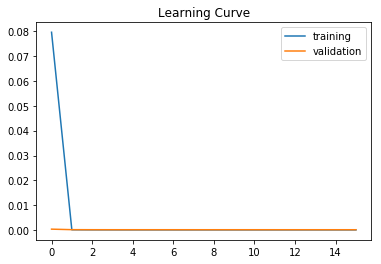

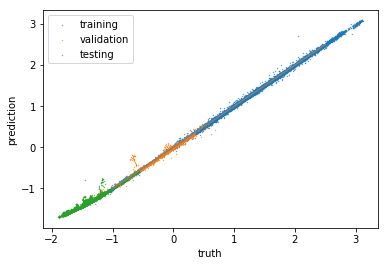

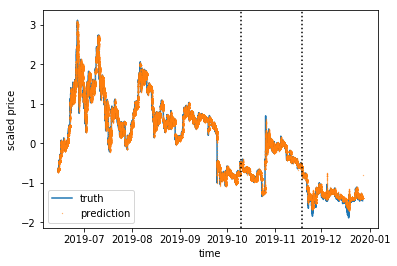

In [7]:
evaluate(input_dir, output_dir, model_dir, seq_len=128)